# __Scenario D:__<br>Time-dependent enzyme inactivation

Data provided by Paulo Durão (Microbial & Enzyme Technology, Instituto de Tecnologia Química e Biológica, Oeiras, Portugal)

## Project background
All investigated enzyme reaction without inhibitor applied to the reaction showed progress curve behavior, which were not explainable by irreversible Michaelis-Menten kinetics. All experiments had in common, that enzyme reactions were carried out in 96-well polystyrene micro titer plates (MTP), whereas the change in substrate or product absorption was monitored photometrically. 
In theory, the observed time-dependent decrease in enzyme activity can either be explained through enzyme inactivation or product inhibition. In case of time-dependent enzyme inactivation, the catalytic activity decreases, since the catalyst becomes inactive. Thereby, the decrease in relative reaction rate is independent from product concentration.
In case of product inhibition, the formed product reduces the reaction rate. Hence, apparent enzyme inactivation is dependent on product concentration.
Since both phenomena express themselves in an apparent decrease of reaction rate, they bare the potential to be confused

One hypothesis for the suspected enzyme inactivation is hydrophobic interaction between the enzyme and the MTP surface. Thereby, hydrophobic regions of the enzyme's surface might interact with the polystyrene reaction vessel, potentially preventing substrate access to the active site of the enzyme.  
In order to test the hypothesis, an absorption experiment in which enzyme was incubated in MTP wells prior to reaction start was performed. Thereby, the enzyme activity should decrease depending on prior incubation time. If the hypothesis is correct, the calculated half life from the adsorption experiment 
should match with the half life of an enzyme kinetics experiment which was conducted in parallel.

__Show results of enzyme inactication across projects__ #TODO

All investigated enzyme reactions in this thesis showed a time-dependent decrease in catalytic activity, which was not explainable with the irreversible Michaelis-Menten model.

### Experimental design

__Determination of enzyme inactivation trough adsorption__  
The inactivation experiment was conducted by incubating CotA laccase from *Bacillus subtilis* in individual MTP wells up to 1 h prior to reaction start.  Then, enzyme reactions were started in 10 min intervals by transferring 2 µL of incubated enzyme in individual MTP wells. Each proceeding enzyme reaction contained 256 nM CotA, 1 mM ABTS and was buffered in acetate buffer at pH 4. Product formation was followed photometrically at 420 nm and 25°C for 5 min, whereas concentrations were calculated assuming an extinction coefficient of ε = 36000 M<sup>-1</sup>cm<sup>-1</sup> for the ABTS radical product. Each experiment was performed in technical triplicates.

__Enzyme kinetics experiment__  
Enzymatic oxidation of ABTS to its radical form was followed photometrically at 420 nm at 25°C for 70 min. 
Thereby, ABTS was applied in a range from 0.01 mM - 2 mM. Each proceeding enzyme reaction contained 256 nM CotA, and was buffered in acetate buffer at pH 4. Each experimental condition was repeated as technical quadruplicates. Concentrations were calculated via the provided extinction coefficient of the ABTS radical (ε = 36000 M<sup>-1</sup>cm<sup>-1</sup>). 

### Experimental data

Measurement data was provided as an Excel file, containing time-course absorption data. Meta data was written into the EnzymeML Excel template. Then, the experimental data was written to an EnzymeML document by a parser function.

## Adsorption of enzyme to micro titer plate surface

### Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import pyenzyme as pe
from EnzymePynetics.tools.parameterestimator import ParameterEstimator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
import string


#TODO warning in EnzymePynetics

import warnings
warnings.filterwarnings('ignore')

### Calculation of inactivation rate
Experimental data was loaded into a Pandas DataFrame and the slopes of each incubation condition were calculated through linear regression. The resulting initial rates were then used to calculate the rate by which the enzyme activity decreases. Lastly the half life of the enzyme was calculated with equation {eq}`enzyme_halflife`.

Calculated enzyme half life based on regression slope: 693.73 h


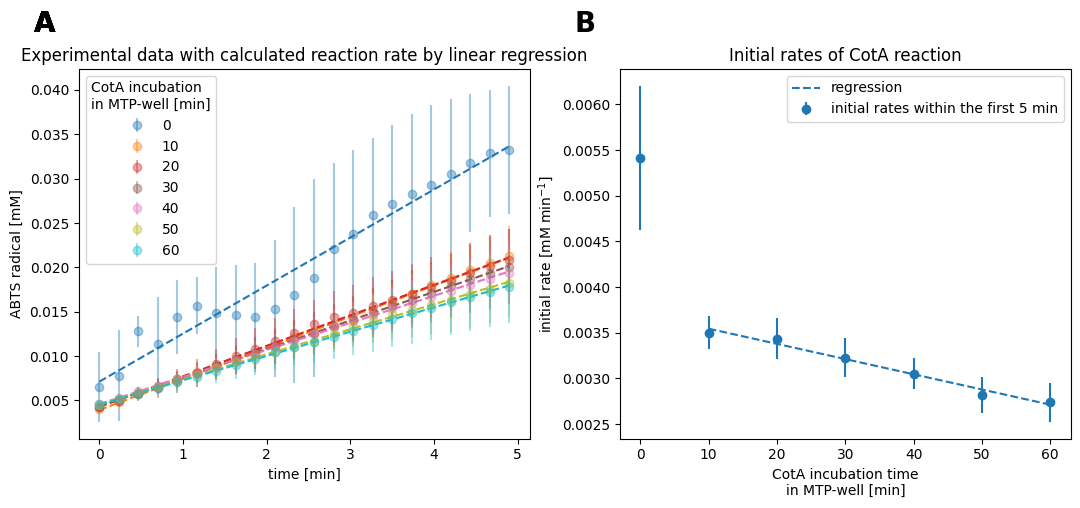

In [2]:
# Load excel
path = '../../data/enzyme_inactivation/Slide 2 - Activity effect of incubating CotA in MTP.xlsx'
df = pd.read_excel(path, sheet_name='csv').set_index('time (min)')

# replace values of '0**' with nan-values, since the measurement is incorrect
df['0**'] = np.nan



# Get data from Excel file
columns = [int(x) for x in list(df.columns) if str(x).endswith("0")]
time = df.index.values
absorption = df.values.T.reshape(7,3,22)

# Calculate concentrations
extinction_coefficient = 36 # (1/mM * 1/cm)
optical_length = 0.65 # cm

def absorption_to_concentration(abso):
    return abso / (extinction_coefficient*optical_length)

concentration = absorption_to_concentration(absorption)
concentration_mean = np.nanmean(concentration, axis = 1)
concentration_std = np.nanstd(concentration, axis = 1)

# Linear regression
slopes = []
intercepts = []
stderrs = []
for time_set in concentration:
    mask = ~np.isnan(time_set)
    time_regression = np.tile(time, 3).reshape(mask.shape)[mask].flatten()
    data_regression = time_set[mask].flatten()
    slope,intercept,_,_,stderr = (linregress(time_regression, data_regression))
    slopes.append(slope)
    intercepts.append(intercept)
    stderrs.append(stderr)

# Regression of the slopes between 10 and 60 mincolumns
slope_of_slopes, intercept_of_slopes,_,_,_ = linregress(columns[1:], slopes[1:])

# Half life in hours
t12 = (np.log(2)/-slope_of_slopes)/60

# Plot results
print(f"Calculated enzyme half life based on regression slope: {t12:.2f} h")

colors = cm.tab10(np.linspace(0, 1, len(absorption)))
fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=False, sharex=False)

for mean, std, label, slope, intercept, color in zip(concentration_mean, concentration_std, columns, slopes, intercepts, colors):
    axes[0].errorbar(time, mean, std, fmt='o', label=label, alpha = 0.4, color=color)
    axes[0].plot(np.array(time), np.array(time)*slope+intercept, '--', color=color)
    axes[0].legend(title="CotA incubation\nin MTP-well [min]")
    axes[0].set_ylabel('ABTS radical [mM]')
    axes[0].set_xlabel('time [min]')
    axes[0].set_title('Experimental data with calculated reaction rate by linear regression')
    axes[0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
            size=20, weight='bold')


axes[1].errorbar(columns, slopes, stderrs, fmt='o', label="initial rates within the first 5 min")
axes[1].set_xlabel("CotA incubation time\nin MTP-well [min]")
axes[1].set_ylabel('initial rate [mM min$^{-1}$]')
axes[1].plot(np.array(columns[1:]), slope_of_slopes*np.array(columns[1:])+intercept_of_slopes, "--", color=colors[0], label=f"regression")
axes[1].legend()
axes[1].set_title('Initial rates of CotA reaction')
axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
        size=20, weight='bold')

plt.show()


_Fig. XXX: Experimental data and regression results of CotA reaction with different enzyme incubation times._

Enzyme reactions without prior incubation showed the fastest reaction rate, whereas all reactions with prior incubation showed an approximately halved reaction rate (Fig. XXXA). Thereby, reactions with longer incubation time showed gradually reduced reaction rates with increased incubation time. Enzyme reactions, especially reactions without incubation, showed large deviations across replicates. This presumably resulted from inhomogeneous mixing or deviating enzyme concentration due to the small volume of enzyme solution, which was used to start the reactions.  
Since the true reaction rate of reactions without prior incubation was highly uncertain and showed mixing issued, the respective data was not used to estimate the enzyme's time-dependent inactivation rate.
Based on the remaining initial reaction rates the enzymes, the half life was estimated at approximately 28 days (Fig. XXXB).

## Enzyme kinetics experiment

### Experimental data 

Experimental data was provided as an Excel file, whereas meta data of the experiment was filled in to an EnzymeML Excel spreadsheet. Measurement data was written to the EnzymeML document by a parser function 
Kinetic parameters were estimated with and without considering enzyme inactivation.


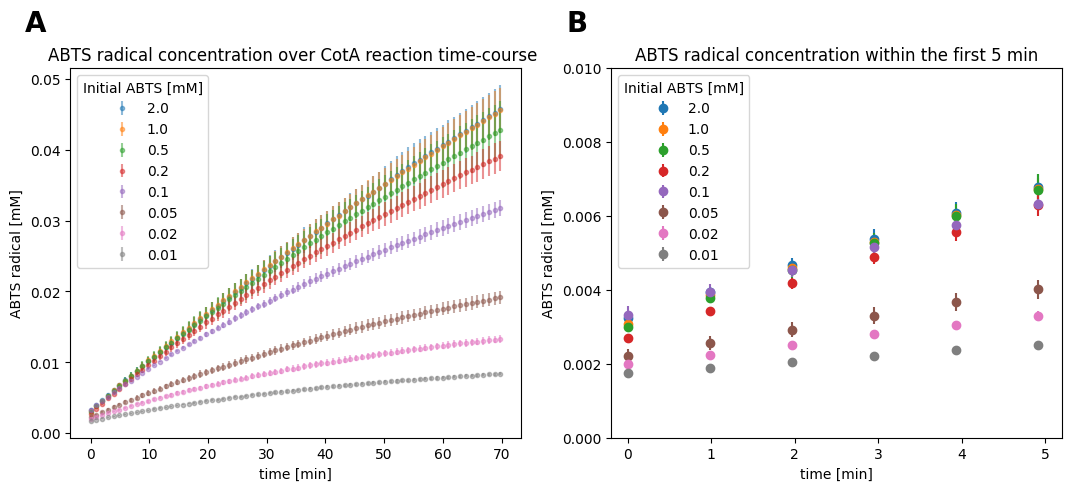

In [3]:
# Load experimental data from excel file
df = pd.read_excel("../../data/enzyme_inactivation/Repetition CotA ABTS kinetics higher volumes 2nd time.xlsx", sheet_name="csv").set_index("Time(min)")
data = df.values.T.reshape(8,4,72)
time = df.index.values

# Calculate concentrations
extinction_coefficient = 36 # (1/mM * 1/cm)
optical_length = 0.65 # cm

def absorption_to_concentration(abso):
    return abso / (extinction_coefficient*optical_length)

concentration_data = absorption_to_concentration(data)


# Parser function
def data_to_EnzymeML(
    template_path: str,
    measurement_data: np.ndarray,
    species_id: str,
    data_unit: str,
    time_unit: str
    ) -> pe.EnzymeMLDocument:

    enzmldoc = pe.EnzymeMLDocument.fromTemplate(template_path)
    for IDs, concentration in zip(enzmldoc.measurement_dict.keys(), measurement_data):
        for counter, replicate in enumerate(concentration):
            rep = pe.Replicate(
                id=f"Measurement{counter}",
                species_id=species_id,
                data=list(replicate),
                data_unit=data_unit,
                time=list(time),
                time_unit=time_unit)
            enzmldoc.getMeasurement(IDs).addReplicates(rep, enzmldoc)
    return enzmldoc

# Write experimantal data to EnzymeML document vis parser function
enzmldoc = data_to_EnzymeML(
    template_path="../../data/enzyme_inactivation/EnzymeML_CotA.xlsm",
    measurement_data=concentration_data,
    species_id="s1",
    data_unit="mmole / l",
    time_unit="min")

# Visualize experimantal data
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=False, sharex=False)
for measurement in enzmldoc.measurement_dict.values():
    concentration = []
    product = measurement.getReactant("s1")
    init_substrate=measurement.getReactant("s0").init_conc
    for replicate in product.replicates:
        concentration.append(replicate.data)
    axes[0].errorbar(time, np.mean(concentration, axis=0), np.std(concentration, axis=0), label=init_substrate,\
        fmt=".", alpha=0.5)
    axes[1].errorbar(time, np.mean(concentration, axis=0), np.std(concentration, axis=0), label=init_substrate,\
        fmt="o")

axes[0].legend(title="Initial ABTS [mM]")
axes[1].legend(title="Initial ABTS [mM]")
axes[0].set_ylabel("ABTS radical [mM]")
axes[0].set_title("ABTS radical concentration over CotA reaction time-course ")
axes[1].set_title("ABTS radical concentration within the first 5 min")
axes[1].set_ylabel("ABTS radical [mM]")
axes[0].set_xlabel("time [min]")
axes[1].set_xlabel("time [min]")
axes[1].set_xlim([-0.2,5.2])
axes[1].set_ylim([0,0.01])
axes[0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
        size=20, weight='bold')
axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
        size=20, weight='bold')

fig.show()


_Fig XXX. ABTS radical concentration over the time-course of CotA reaction._

The provided reaction data showed large deviations between individual repeats of reactions with identical initial ABTS concentrations. Especially for initial ABTS concentrations above 0.1 mM (Fig. XXXA).
Furthermore, visual analysis of the initial measurement points indicated that reactions with an initial substrate concentration of 0.1 mM had an increased enzyme concentration compared to others. This is evident, because the mentioned reactions show the highest concentration at the initial measurement time (Fig. XXXB). The order of initial measurement points is expected to reflect the initial substrate concentrations and since the substrate slightly absorbs at the product detection wavelength. The substrate of the mentioned reaction was likely applied correctly, since the final concentration at 70 min is between reactions with the next lower and next higher initial substrate concentration.

## Kinetic parameter estimation

### Quality control through modeling
An initial parameter estimation considering enzyme inactivation was conducted in order to check further systematic deviations. As a result, reactions with an initial ABTS concentration of 0.05 mM showed to deviate from all other reactions, since the respective product concentrations is lower than the model predicted. The mentioned measurements were the only measurements where the measured concentration was distinctly and systematically below that of the model (Fig. xxxA). Hence indicating that either less substrate or enzyme than defined in the protocol was applied to the respective reactions. In consequence, data from reactions with an initial substrate concentration of 0.05 and 0.1 mM were excluded from parameter estimation, because the identified systematic deviations in reaction conditions would distort the results.

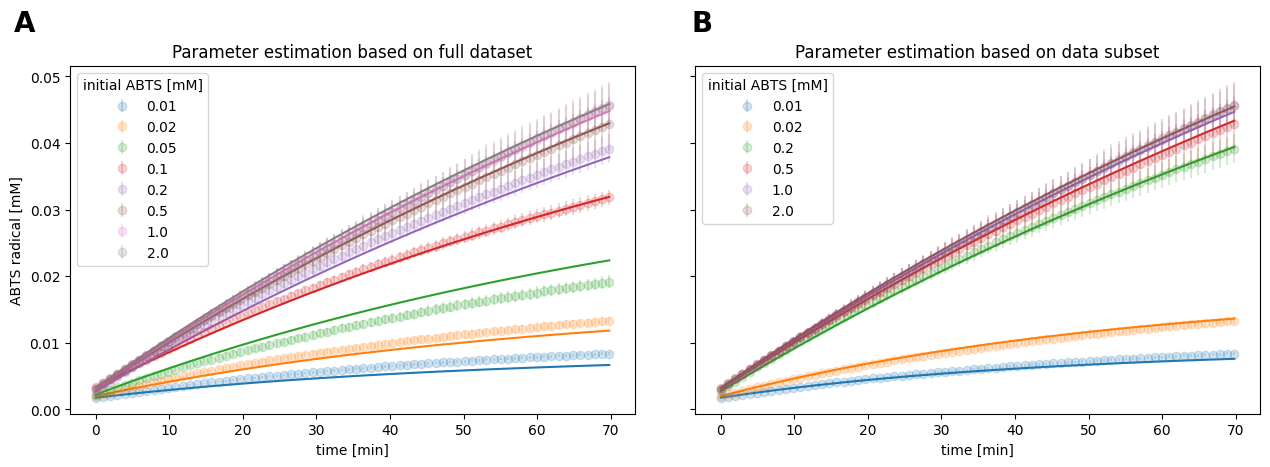

In [4]:
# Parameter estimation considering time-dependent enzyme inactivation
CotA_kinetics_first_run = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics_first_run.fit_models(enzyme_inactivation=True, display_output=False, initial_substrate_concs=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0])

# Parameter estimation considering time-dependent enzyme inactivation
CotA_kinetics_with_inactivation = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics_with_inactivation.fit_models(enzyme_inactivation=True, display_output=False, initial_substrate_concs=[0.01, 0.02, 0.2, 0.5, 1.0, 2.0])
df_inactivation = CotA_kinetics_with_inactivation.result_dict.drop(columns=["kcat / Km [1/min * 1/mmole / l]"])
df_inactivation.insert(1, "Enzyme inactivation model", "True")

# Visualize fit of the models
fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=True, sharex=True)
CotA_kinetics_first_run.visualize("irreversible Michaelis Menten",ax=axes[0], alpha =.2,\
    title="Parameter estimation based on full dataset")
CotA_kinetics_with_inactivation.visualize("irreversible Michaelis Menten",ax=axes[1], alpha =.2,\
    title="Parameter estimation based on data subset")

axes[0].set_ylabel("ABTS radical [mM]")
axes[0].set_xlabel("time [min]")
axes[1].set_xlabel("time [min]")
axes[0].legend(title="initial ABTS [mM]")
axes[1].legend(title="initial ABTS [mM]")
axes[0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
        size=20, weight='bold')
axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
        size=20, weight='bold')
plt.tight_layout()

_Fig XXX: Identification of systematic deviations through kinetic modeling._

By excluding the mentioned measurements, the fit of the model to the remaining data was improved (Fig xxxB). Additionally, the correlation between parameter estimates for $k_{cat}$ and $K_{m}$ was reduced from 0.518 to 0.204
### Parameter estimation with and without considering enzyme inactivation


In [5]:
# Parameter estimation without time-dependent enzyme inactivation
CotA_kinetics = ParameterEstimator.from_EnzymeML(enzmldoc, "s1", "product")
CotA_kinetics.fit_models(enzyme_inactivation=False, display_output=False, initial_substrate_concs=[0.01, 0.02, 0.2, 0.5, 1.0, 2.0])
df = CotA_kinetics.result_dict.drop(columns=["kcat / Km [1/min * 1/mmole / l]"])
df.insert(1, "Enzyme inactivation model", "False")

results = df.append(df_inactivation).sort_values("AIC")
display(results.style.set_table_attributes('style="font-size: 12px"'))

,AIC,Enzyme inactivation model,kcat [1/min],Km [mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l],ki time-dep enzyme-inactiv. [1/min]
irreversible Michaelis Menten,-22202,True,3.003 +/- 0.77%,0.030 +/- 1.99%,-,-,0.007 +/- 4.48%
competitive product inhibition,-22202,True,2.999 +/- 0.78%,0.029 +/- 3.85%,0.221 +/- 92.18%,-,0.007 +/- 5.06%
substrate inhibition,-22202,True,3.021 +/- 0.86%,0.031 +/- 2.38%,-,208.577 +/- 67.12%,0.007 +/- 4.48%
uncompetitive product inhibition,-22199,True,3.012 +/- 1.23%,0.030 +/- 4.72%,-,2.096 +/- 361.49%,0.006 +/- 15.30%
non-competitive product inhibition,-22198,True,3.012 +/- 2.44%,0.029 +/- 6.56%,0.167 +/- 132.63%,1.113 +/- 466.95%,0.006 +/- 40.69%
non-competitive product inhibition,-22185,False,3.241 +/- 1.40%,0.033 +/- 5.05%,0.038 +/- 22.41%,0.073 +/- 6.86%,nan
uncompetitive product inhibition,-22156,False,3.268 +/- 1.43%,0.041 +/- 2.70%,-,0.066 +/- 6.35%,nan
competitive product inhibition,-21840,False,2.586 +/- 0.35%,0.020 +/- 6.10%,0.016 +/- 15.88%,-,nan
irreversible Michaelis Menten,-21739,False,2.529 +/- 0.27%,0.030 +/- 2.30%,-,-,nan
substrate inhibition,-21737,False,2.537 +/- 0.52%,0.030 +/- 2.71%,-,352.069 +/- 134.63%,nan


Kinetic parameters were estimated with and without considering time-dependent enzyme inactivation. 
Modeling results are listed in the table above. All models with an additional parameter for enzyme inactivation resulted in lower AIC values, indicating a better fit of the experimental data to inactivation models. Irreversible Michaelis-Menten model resulted in the highest AIC together with competitive product inhibition as well as substrate inhibition all considering enzyme inactivation. Nevertheless, all inhibition models considering enzyme inactivation showed high standard deviation above 80% for the respective estimate of $K_{i}$.

Estimates for $k_{cat}$ ranged from 2.58 min<sup>-1</sup> to 3.41 min<sup>-1</sup>, where $K_{m}$ estimates ranged from 23 µM to 62 µM depending on the kinetic model.
Based on the resulting $k_{inact}$, the enzyme's half life was estimated to 95 min, using equation [](enzyme_halflife). 
Since AIC does not consider uncertainties of parameteres, they need to be assessed for model evaluation.

#### Kinetic models with enzyme inactivation
For models with enzyme inactivation, the substrate inhibition model showed the lowest AIC and low standard deviations on the estimated parameters. The irreversible Michaelis-Menten model had the least amount of parameters and showed even lower standard deviations on the parameter estimates, compared to the substrate inhibition model. Product inhibition models showed generally higher standard deviation on the estimated inhibition parameters. Thus, the two models shown in figure xxx describe the data the best in therms of kinetic parameter standard deviations.

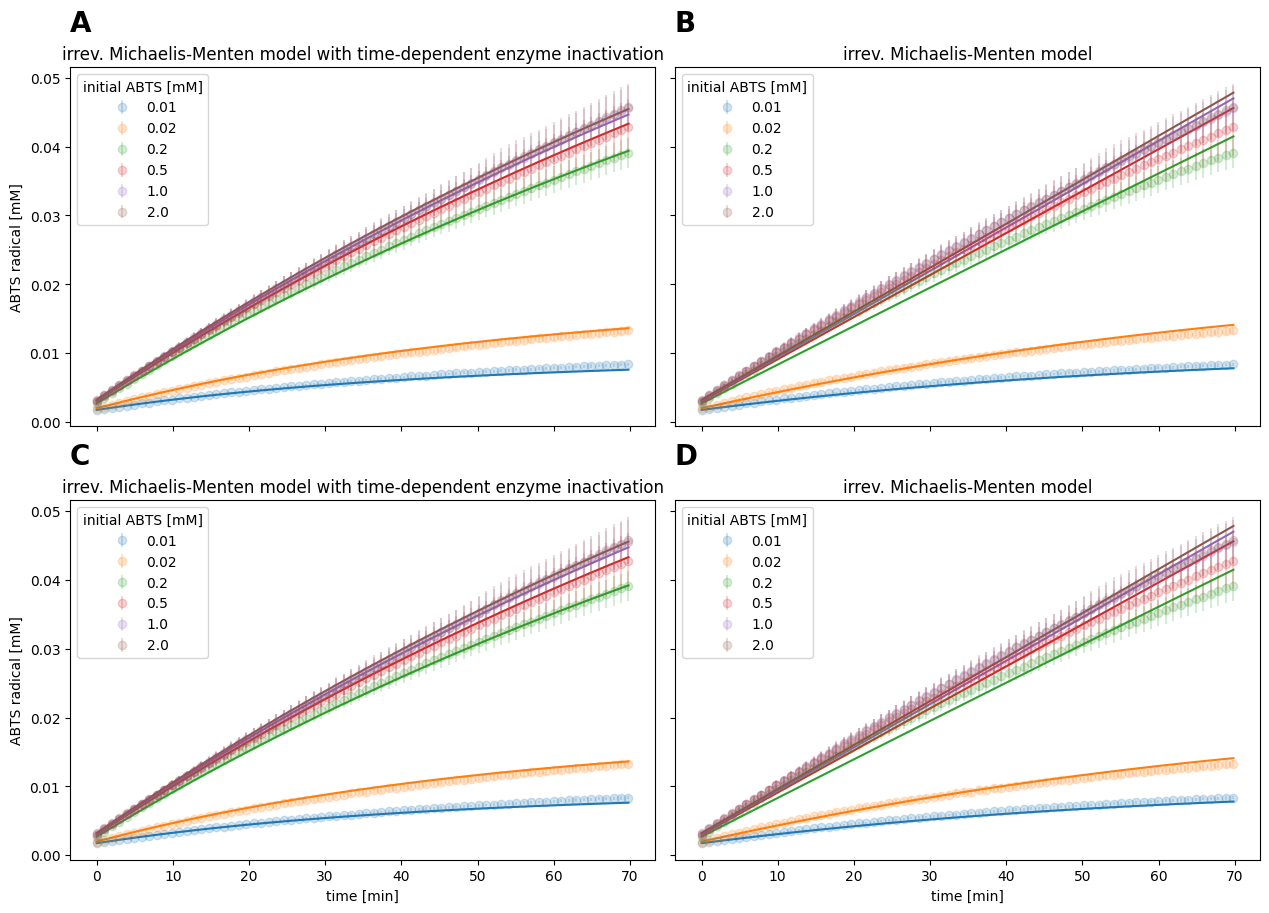

In [39]:
fig, axes = plt.subplots(2,2, figsize=(12.8,9.2), sharey=True, sharex=True)
CotA_kinetics_with_inactivation.visualize("irreversible Michaelis Menten",ax=axes[0][0], alpha =.2,\
    title="irrev. Michaelis-Menten model with time-dependent enzyme inactivation")
CotA_kinetics.visualize("irreversible Michaelis Menten",ax=axes[0][1], alpha =.2,\
    title="irrev. Michaelis-Menten model")
CotA_kinetics_with_inactivation.visualize("competitive product inhibition",ax=axes[1][0], alpha =.2,\
    title="irrev. Michaelis-Menten model with time-dependent enzyme inactivation")
CotA_kinetics.visualize("irreversible Michaelis Menten",ax=axes[1][1], alpha =.2,\
    title="irrev. Michaelis-Menten model")

axes[0][0].set_ylabel("ABTS radical [mM]")
axes[1][0].set_ylabel("ABTS radical [mM]")
axes[1][0].set_xlabel("time [min]")
axes[1][1].set_xlabel("time [min]")
[ax.legend(title="initial ABTS [mM]") for ax in axes.flatten()]

[ax.text(0, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold') for i, ax in enumerate(axes.flatten())]

# axes[0]
# axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
#         size=20, weight='bold')
plt.tight_layout()

_Fig. XXX: Substrate inhibition and irreversible Michealis-Menten model fitted to CotA reaction data_

Visually, both models in figure xxx describe the observed concentration time-course of ABTS radical formation. For both models, measurement data from enzyme reactions with initial substrate concentrations below 0.1 mM deviate more strongly from the model compared to higher concentrations. Since the measured absorption values were not blanked, all calculated concentrations are falsely increased. This effect is more severe for low initial substrate concentrations, since the absorption contribution from buffer is lager compared to the accumulating product for low concentrations. Measurement data from reactions with an initial substrate concentration of 0.05 mM was lower  compared to all fitted model throughout the reaction. Therefore, less substrate or enzyme than specified was applied to the reaction.  
For reactions with initial substrate concentrations above 0.1 mM, both models describe the progress curve of the reaction. Due to high standard deviation between the repeats, the true reaction rate at high substrate concentrations is unknown. Therefore, neither substrate inhibition nor irreversible Michaelis-Menten model were able to clearly represent the experimental data.

#### Kinetic models without enzyme inactivation
In therms of AIC, product inhibition models without considering enzyme inactivation described the data the best, whereas substrate inhibition and irreversible Michaelis-Menten model resulted in the highest AIC of all models. In therms of estimated parameters, irreversible Michaelis-Menten model showed the lowest standard deviation for the parameter estimates.  


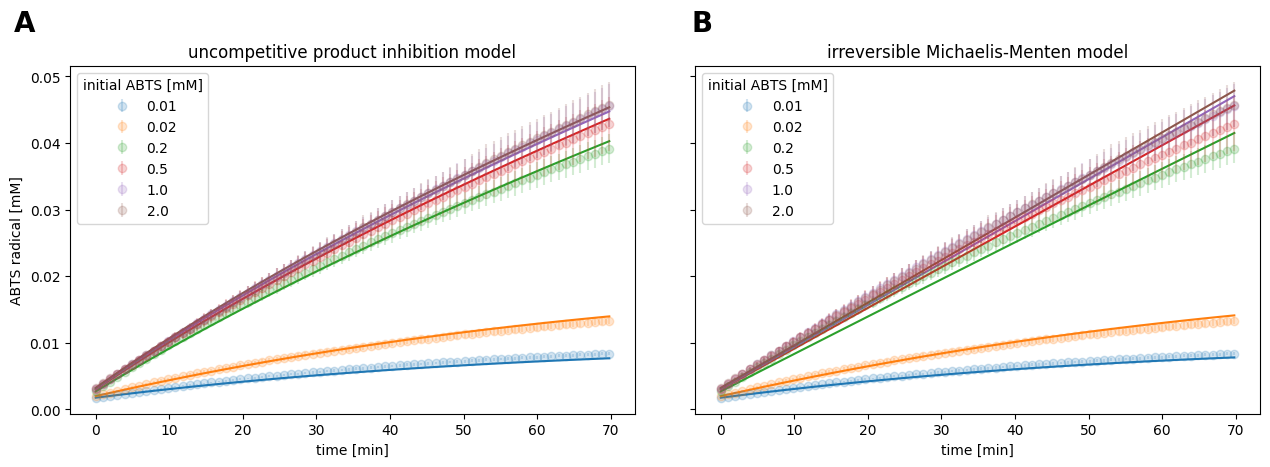

In [7]:
fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=True, sharex=True)
CotA_kinetics.visualize("uncompetitive product inhibition",ax=axes[0], alpha =.2,\
    title="uncompetitive product inhibition model")
CotA_kinetics.visualize("irreversible Michaelis Menten",ax=axes[1], alpha =.2,\
    title="irreversible Michaelis-Menten model")

axes[0].set_ylabel("ABTS radical [mM]")
axes[0].set_xlabel("time [min]")
axes[1].set_xlabel("time [min]")
axes[0].legend(title="initial ABTS [mM]")
axes[1].legend(title="initial ABTS [mM]")
axes[0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
        size=20, weight='bold')
axes[1].text(1.1, 1.1, string.ascii_uppercase[1], transform=axes[0].transAxes, 
        size=20, weight='bold')
plt.tight_layout()

Visually, the best AIC model and the best model in regard to parameter standard deviation (Fig. XXX, left and right respectively), both underestimate the reaction velocity of the first 50 min. After 50 min the uncompetitive product inhibition model 

## Conclusion

__Low data quality__

Experimental data of the data set for parameter estimation showed low quality. This was indicated by high deviations between experimental repeats as well as 

__Enzyme inactivation__
Models considering time-dependent enzyme inactivation describe reaction progress curves better compared to models without enzyme inactivation. Product inhibition models 


Parameter estimation with kinetic models considering enzyme inactivation leads to opposing conclusion of the kinetic mechanism. 
Not considering enzyme inactivation would lead to the assumption of product inhibition